# Boat Type Classification using CNN and Transfer Learning

This project classifies boat types using deep learning. We compare a custom CNN against a MobileNetV2 transfer learning model. The goal is to improve generalization and handle class imbalance using augmentation and oversampling.

Key Focus:
- Preprocessing (balancing, augmentation)
- Model 1: Custom CNN
- Model 2: MobileNetV2 (with regularization and learning rate scheduler)
- Evaluation: Accuracy, F1-score, Confusion Matrix


In [1]:
# IMPORTS

import os
import pathlib

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from tensorflow.keras import layers, models, utils, Sequential, losses, preprocessing
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dropout, Dense, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.metrics import accuracy_score, f1_score

model_mobile = MobileNetV2()

14536120/14536120 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [2]:
from google.colab import drive
drive.mount('/content/drive')

data_dir = pathlib.Path('/content/drive/MyDrive/Automating Port Operations_Dataset')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
data_dir

PosixPath('/content/drive/MyDrive/Automating Port Operations_Dataset')

In [4]:
boat_imgs = list(data_dir.glob('**/*.jpg')) + list(data_dir.glob('**/*.jpeg'))

print(f"Found {len(boat_imgs)} images.")

Found 1168 images.


In [5]:
import pandas as pd

# Assuming folder structure like: boat_type_classification_dataset/sailboat/image1.jpeg
df = pd.DataFrame({
    'file_path': [str(p) for p in boat_imgs],
    'label': [p.parent.name for p in boat_imgs]  # label is parent folder name
})

df['label'].value_counts()

,count
label,
sailboat,389
kayak,203
gondola,193
cruise_ship,191
ferry_boat,63
buoy,59
paper_boat,31
freight_boat,23
inflatable_boat,16


In [6]:
Unique_labels = df['label'].unique()
print(f"Total number of unique labels: {len(Unique_labels)}")

Total number of unique labels: 9


- Loaded images from Google Drive
- Stratified split: 64% train, 16% val, 20% test
- Oversampled minority classes
- Used `ImageDataGenerator` for augmentation


In [7]:
# First split: 80% train_val, 20% test
train_val_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=43, shuffle=True)

# Second split: 80% train, 20% val from train_val
train_df, val_df = train_test_split(train_val_df, test_size=0.2, stratify=train_val_df['label'], random_state=43, shuffle=True)


In [8]:
class_counts = (train_df['label'].value_counts() / len(train_df)) * 100

# Format to 4 decimal places and add %
formatted = class_counts.apply(lambda x: f"{x:.2f}%")

print(formatted)


label
sailboat           33.33%
kayak              17.40%
gondola            16.47%
cruise_ship        16.33%
ferry_boat          5.35%
buoy                5.09%
paper_boat          2.68%
freight_boat        2.01%
inflatable_boat     1.34%
Name: count, dtype: object


# oversampling of **minority classes**

In [9]:
# Define minority threshold (e.g., < threshold count)
class_counts = train_df['label'].value_counts()
minority_classes = class_counts[class_counts < 20].index.tolist()

# Split dataframe into majority and minority
minority_df = train_df[train_df['label'].isin(minority_classes)]

# Optionally oversample minority class
oversampled_minority_df = pd.concat([minority_df] * 5, ignore_index=True)

# Majority class
majority_df = train_df[~train_df['label'].isin(minority_classes)]

# Combine them
balanced_train_df = pd.concat([majority_df, oversampled_minority_df], ignore_index=True)



In [10]:
balanced_class_counts = (balanced_train_df['label'].value_counts() / len(balanced_train_df)) * 100

# Format to 4 decimal places and add %
formatted_2 = balanced_class_counts.apply(lambda x: f"{x:.2f}%")

print(formatted_2)

label
sailboat           29.40%
kayak              15.35%
gondola            14.52%
cruise_ship        14.40%
freight_boat        8.85%
inflatable_boat     5.90%
ferry_boat          4.72%
buoy                4.49%
paper_boat          2.36%
Name: count, dtype: object


# **Augmentation** of minority classes(rotation, rescale, zoom, flip, etc.)

In [11]:
#  augmentation for minority
minority_aug = preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.2,
    horizontal_flip=True
)

# NO augmentation for majority
majority_aug = preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

# Validation and test - rescaling only
plain_gen = preprocessing.image.ImageDataGenerator(rescale=1./255)

| Stage                       | Subset Name         | Source                   | Processing Steps                             | Purpose                                 |
|----------------------------|---------------------|--------------------------|----------------------------------------------|-----------------------------------------|
| Original dataset           | `train_df`          | Labeled dataset (csv/folder) | None                                       | Full dataset to be split and prepped    |
| Train-validation split     | `train_core_df`     | Subset of `train_df`     | Stratified split (e.g., 80%)                | Used for training                        |
|                            | `val_df`            | Subset of `train_df`     | Stratified split (e.g., 20%)                | Used for validation                      |
| Oversampling               | `oversampled_minority_df` | From `train_core_df` | Duplicate rare-class rows                  | Balance class distribution              |
| Majority set               | `majority_df`       | From `train_core_df`     | No duplication                             | Preserve original majority distribution |
| Augmentation applied       | `minority_gen`      | From `oversampled_minority_df` | Strong augmentation + rescale (ImageDataGenerator) | Increase diversity for minority classes |
|                            | `majority_gen`      | From `majority_df`       | Light or no augmentation + rescale         | Maintain consistency for majority class |
| Generator merge            | `train_combined`    | `minority_gen + majority_gen` | Zip/combine batches                        | Unified training input to model         |
| Validation generator       | `val_gen`           | From `val_df`            | Rescale only, no augmentation              | Model tuning and early stopping         |
| Test generator             | `test_gen`          | Separate held-out set     | Rescale only, no augmentation              | Final unbiased performance evaluation   |


In [12]:
class_list = sorted(df['label'].unique().tolist())


# Minority generator
minority_gen = minority_aug.flow_from_dataframe(
    dataframe=oversampled_minority_df,
    x_col='file_path',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    classes=class_list
)

# Majority generator
majority_gen = majority_aug.flow_from_dataframe(
    dataframe=majority_df,
    x_col='file_path',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    classes=class_list
)

# Combine majority and minority train generators
import numpy as np

def combined_generator(gen1, gen2):
    while True:
        x1, y1 = next(gen1)
        x2, y2 = next(gen2)
        yield np.concatenate([x1, x2]), np.concatenate([y1, y2])

train_combined = combined_generator(minority_gen, majority_gen)



# Validation generator
val_gen = plain_gen.flow_from_dataframe(
    dataframe=val_df,
    x_col='file_path',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
    classes=class_list
)

# Test generator
test_gen = plain_gen.flow_from_dataframe(
    dataframe=test_df,
    x_col='file_path',
    y_col='label',  # If test labels exist; otherwise use class_mode=None
    target_size=(224, 224),
    class_mode='categorical',  # Or None if labels are missing
    batch_size=32,
    shuffle=False,
    classes=class_list
)


Found 125 validated image filenames belonging to 9 classes.
Found 722 validated image filenames belonging to 9 classes.
Found 187 validated image filenames belonging to 9 classes.
Found 234 validated image filenames belonging to 9 classes.


In [13]:
from tensorflow.keras import models, layers, metrics

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.GlobalAveragePooling2D(),

    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),

    layers.Dense(9, activation='softmax')  # Replace 9 if needed
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=[metrics.CategoricalAccuracy(name="Accuracy"),
                  metrics.Precision(name="precision"),
                  metrics.Recall(name="recall")]) # Added closing parenthesis here
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 32)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,041 (125.16 KB)

 Trainable params: 32,041 (125.16 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Calculate steps per epoch for training and validation
# Use the length of the balanced_train_df for the total number of training samples
steps_per_epoch = len(balanced_train_df) // 32 # Divide by batch size
validation_steps = len(val_df) // 32 # Divide by batch size

early_stop = EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(
    train_combined,
    steps_per_epoch=steps_per_epoch,
    epochs=20, # Set epochs to 20 as per project description
    validation_data=val_gen,
    validation_steps=validation_steps,
    callbacks=[early_stop]
)

Epoch 1/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - Accuracy: 0.2836 - loss: 2.0354 - precision: 0.1506 - recall: 5.0792e-04 

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


26/26 ━━━━━━━━━━━━━━━━━━━━ 418s 16s/step - Accuracy: 0.2840 - loss: 2.0325 - precision: 0.1543 - recall: 5.1181e-04 - val_Accuracy: 0.0250 - val_loss: 2.3192 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - Accuracy: 0.2995 - loss: 1.8702 - precision: 0.0212 - recall: 9.3718e-05 - val_Accuracy: 0.0250 - val_loss: 2.2773 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 21s 827ms/step - Accuracy: 0.3090 - loss: 1.8549 - precision: 0.0771 - recall: 0.0015 - val_Accuracy: 0.0437 - val_loss: 2.2539 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 25s 995ms/step - Accuracy: 0.3575 - loss: 1.7564 - precision: 0.4868 - recall: 0.0476 - val_Accuracy: 0.1000 - val_loss: 2.1501 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - Accuracy: 0.3844 - loss: 1.7297 - precision: 0.5712 - recall: 0.0706 - val_Accu

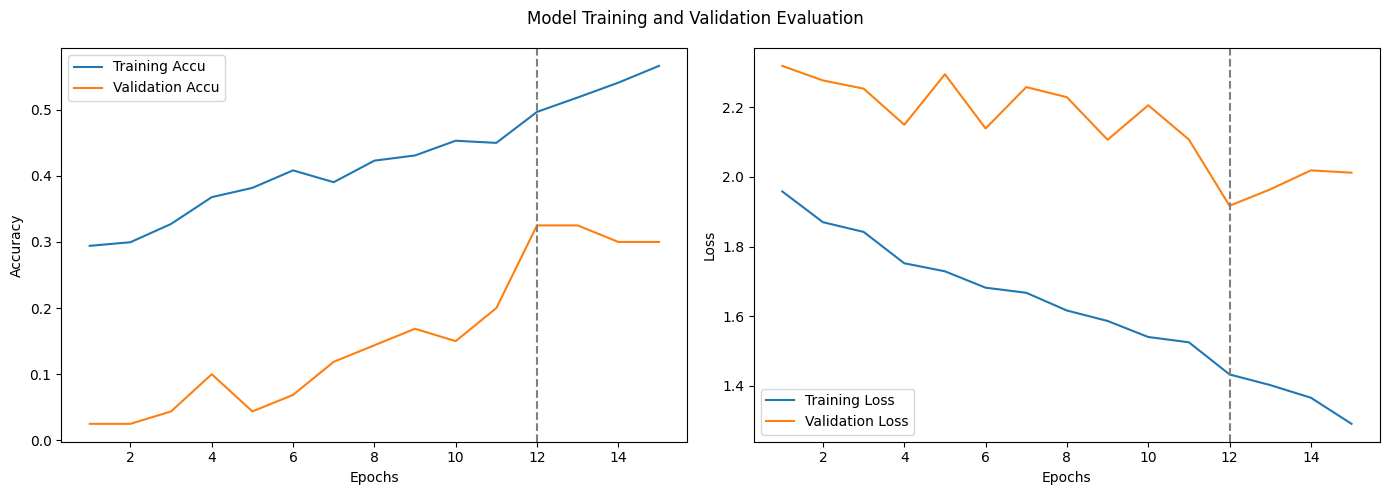

In [15]:
epochs_ran = len(history.history['Accuracy'])
fig, (plt1, plt2) = plt.subplots(1,2, figsize=(14,5))
epoch_x_axis = range(1, epochs_ran + 1)
plt1.plot(epoch_x_axis, history.history['Accuracy'], label='Training Accu')
plt1.plot(epoch_x_axis, history.history['val_Accuracy'], label='Validation Accu')
plt1.set_ylabel('Accuracy')
plt1.set_xlabel('Epochs')
#early stopping line
plt1.axvline(x=epochs_ran-3, linestyle='--', color='gray')
plt1.legend()

plt2.plot(epoch_x_axis, history.history['loss'], label='Training Loss')
plt2.plot(epoch_x_axis, history.history['val_loss'], label='Validation Loss')
plt2.set_ylabel('Loss')
plt2.set_xlabel('Epochs')
plt2.axvline(x=epochs_ran-3, linestyle='--', color='gray')
plt2.legend()

fig.suptitle('Model Training and Validation Evaluation')
fig.tight_layout()

# Probabilities or labels for visualizing preductions or computing F1 scores

In [16]:
probs = model.predict(test_gen)         # shape: (n_samples, n_classes)
pred_labels = np.argmax(probs, axis=1)  # predicted class indices
true_labels = test_gen.classes          # ground truth


8/8 ━━━━━━━━━━━━━━━━━━━━ 89s 13s/step


In [17]:
from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(true_labels, pred_labels))
print(classification_report(true_labels, pred_labels, target_names=test_gen.class_indices.keys()))


[[ 0  0  0  6  2  0  1  0  3]
 [ 0 12  0  7  4  4  0  0 11]
 [ 0  3  0  1  2  4  1  0  2]
 [ 0  1  0  0  0  2  0  0  1]
 [ 0  1  0  5 20  4  3  0  6]
 [ 0  0  0  0  1  1  0  0  1]
 [ 0  3  0 14  7  8  1  0  8]
 [ 0  0  0  3  0  2  0  0  1]
 [ 0  8  0 26 14  5  0  0 25]]
                 precision    recall  f1-score   support

           buoy       0.00      0.00      0.00        12
    cruise_ship       0.43      0.32      0.36        38
     ferry_boat       0.00      0.00      0.00        13
   freight_boat       0.00      0.00      0.00         4
        gondola       0.40      0.51      0.45        39
inflatable_boat       0.03      0.33      0.06         3
          kayak       0.17      0.02      0.04        41
     paper_boat       0.00      0.00      0.00         6
       sailboat       0.43      0.32      0.37        78

       accuracy                           0.25       234
      macro avg       0.16      0.17      0.14       234
   weighted avg       0.31      0.25      0

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model 2: MobileNetV2 (Transfer Learning)

In [18]:
def mobile_model(image_size=(224, 224), num_classes=9):
    base_model = MobileNetV2(input_shape=(image_size[0], image_size[1], 3),
                             include_top=False,
                             weights='imagenet')

    # Freeze all layers initially
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    return model


In [19]:
model_mobile = mobile_model() # Create an instance of the model

model_mobile.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=[
        metrics.CategoricalAccuracy(name="Accuracy"),
        metrics.Precision(name="Precision"),
        metrics.Recall(name="Recall")
    ]
)

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=1, min_lr=1e-6)

model_ckpt = ModelCheckpoint("best_mobile_model.h5", monitor='val_accuracy', save_best_only=True, verbose=1)

# Training
history_mobile = model_mobile.fit(
    train_combined,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_gen,
    validation_steps=validation_steps,
    epochs=30,
    callbacks=[early_stop, lr_scheduler, model_ckpt]
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 60s 2s/step - Accuracy: 0.1812 - Precision: 0.2132 - Recall: 0.0748 - loss: 3.3302 - val_Accuracy: 0.1875 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_loss: 2.7352 - learning_rate: 1.0000e-04
Epoch 2/30
 2/26 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - Accuracy: 0.3867 - Precision: 0.5130 - Recall: 0.1719 - loss: 2.5786

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:209: UserWarning: Can save best model only with val_accuracy available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 23s 900ms/step - Accuracy: 0.3988 - Precision: 0.5357 - Recall: 0.2199 - loss: 2.4187 - val_Accuracy: 0.5188 - val_Precision: 1.0000 - val_Recall: 0.0375 - val_loss: 2.2961 - learning_rate: 1.0000e-04
Epoch 3/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - Accuracy: 0.5555 - Precision: 0.7078 - Recall: 0.3795 - loss: 1.9636 - val_Accuracy: 0.6313 - val_Precision: 0.9091 - val_Recall: 0.1875 - val_loss: 1.9619 - learning_rate: 1.0000e-04
Epoch 4/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 20s 777ms/step - Accuracy: 0.6614 - Precision: 0.8233 - Recall: 0.5192 - loss: 1.6559 - val_Accuracy: 0.6875 - val_Precision: 0.9459 - val_Recall: 0.4375 - val_loss: 1.7254 - learning_rate: 1.0000e-04
Epoch 5/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 24s 940ms/step - Accuracy: 0.7379 - Precision: 0.8586 - Recall: 0.6297 - loss: 1.4514 - val_Accuracy: 0.7312 - val_Precision: 0.9255 - val_Recall: 0.5437 - val_loss: 1.5576 - learning_rate: 1.0000e-04
Epoch 6/30
26/26 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - Accura

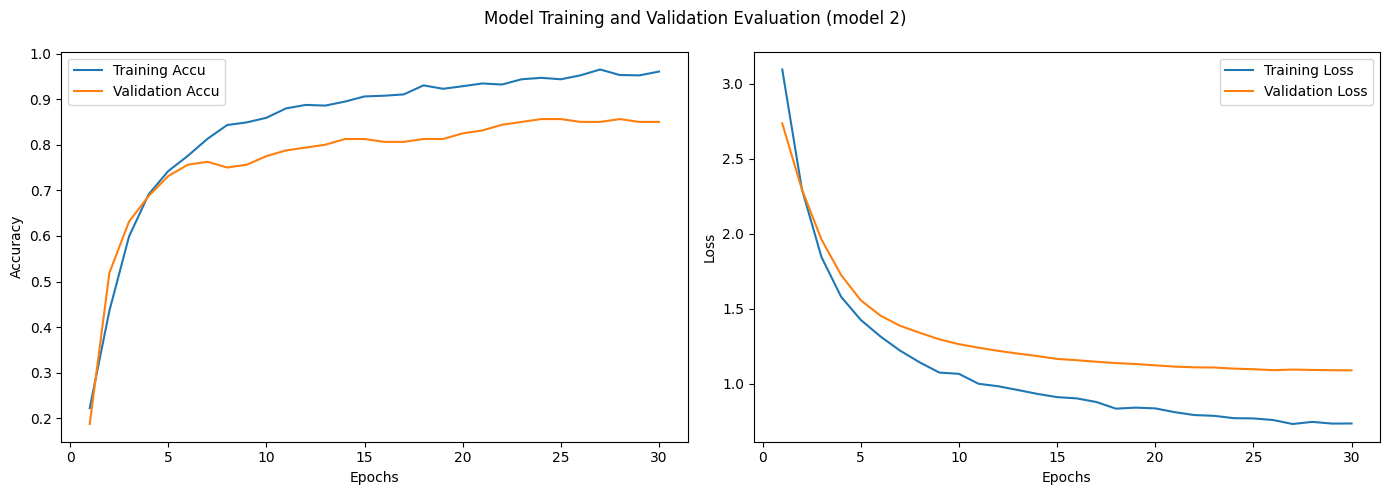

In [24]:
epochs_ran = len(history_mobile.history['Accuracy'])
fig, (plt1, plt2) = plt.subplots(1,2, figsize=(14,5))
epoch_x_axis = range(1, epochs_ran + 1)
plt1.plot(epoch_x_axis, history_mobile.history['Accuracy'], label='Training Accu')
plt1.plot(epoch_x_axis, history_mobile.history['val_Accuracy'], label='Validation Accu')
plt1.set_ylabel('Accuracy')
plt1.set_xlabel('Epochs')


plt1.legend()

plt2.plot(epoch_x_axis, history_mobile.history['loss'], label='Training Loss')
plt2.plot(epoch_x_axis, history_mobile.history['val_loss'], label='Validation Loss')
plt2.set_ylabel('Loss')
plt2.set_xlabel('Epochs')

plt2.legend()

fig.suptitle('Model Training and Validation Evaluation (model 2)')
fig.tight_layout()

### Key Takeaways

- The **custom CNN** showed acceptable training accuracy but limited generalization.
- The **MobileNetV2 model** (with freezing, dropout, regularization) showed better **generalization** but was overfitting until scheduler & dropout were added.
- Augmentation and oversampling helped address class imbalance.

**Recommendation:** Use MobileNetV2 with fine-tuned top layers and regularization for final deployment. Additional tuning (more data, class weights, augmentation) can help further.
